In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
import torch

set_log_level(30)

/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
g = 9.81
R = 287.0
T_gas = 300.0
L = 10.0
N = 200
T= 5.0

mesh = IntervalMesh(N, 0, L)


dx_cell = L / N
CFL = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

def two_phase_simulator(theta, T=10.0, N=200, L=10.0, seed=None, return_full=False):
    """
    theta: [C_wall_L, C_wall_G, C_int, theta_incline]
    Returns:
        (timesteps+1, N) array of alpha_L, or optionally all fields.
    """
    # Unpack
    C_wall_L, C_wall_G, C_int, theta_pipe, h_sed = theta

    rho_L = 800
    rho_G = 1.2

    if seed is not None:
        np.random.seed(seed)


    # Initial holdup and velocity profiles
    V = FunctionSpace(mesh, "DG", 0)
    x = SpatialCoordinate(mesh)
    alpha_L0 = project(0.5 + 0.15 * sin(2 * np.pi * x[0] / L), V)
    alpha_G0 = project(1.0 - (0.5 + 0.15 * sin(2 * np.pi * x[0] / L)), V)
        
    # if use_sediment:
    #     h_sed = 0.02

    C_wall_L_effective = C_wall_L * (1 + 150 * h_sed)

    u_L0 = 1.0 + .2 * np.sin(np.pi * cell_centers / L)
    u_G0 = 2.0 + .1 * np.cos(np.pi * cell_centers / L)

    dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
    timesteps = int(T / dt)

    alpha_L_n = Function(V)
    alpha_G_n = Function(V)
    alpha_L_n.assign(alpha_L0)
    alpha_G_n.assign(alpha_G0)
    u_L_n = u_L0.copy()
    u_G_n = u_G0.copy()

    all_data_L = np.zeros((timesteps+1, V.dim()))
    all_data_G = np.zeros((timesteps+1, V.dim()))
    all_data_uL = np.zeros((timesteps+1, V.dim()))
    all_data_uG = np.zeros((timesteps+1, V.dim()))
    all_data_L[0, :] = alpha_L_n.vector().get_local()
    all_data_G[0, :] = alpha_G_n.vector().get_local()
    all_data_uL[0, :] = u_L_n
    all_data_uG[0, :] = u_G_n

    def compute_geometries(alpha):
        r = max(0.01, 0.05 - h_sed)
        h_int = np.clip(r * (2 * alpha - 1), -r + 1e-8, r - 1e-8)
        r2 = r * r
        root_h = np.sqrt(r2 - h_int**2)
        A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
        A_G = r2 * np.arccos(h_int/r) - h_int * root_h
        P_LG = 2 * root_h
        P_LW = 2 * r * np.arccos(-h_int/r)
        P_GW = 2 * r * np.arccos(h_int/r)
        return h_int, A_L, A_G, P_LG, P_LW, P_GW

    for step in range(1, timesteps+1):
        alpha_L = alpha_L_n.vector().get_local()
        alpha_G = alpha_G_n.vector().get_local()
        u_L = u_L_n.copy()
        u_G = u_G_n.copy()

        # Geometry
        h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L)
        p_int = np.full_like(alpha_L, rho_G * R * T_gas)
        # Hydrostatic pressure (linear)
        p_av_L = p_int + rho_L * g * (h_int) * np.sin(theta_pipe)
        p_av_G = p_int + rho_G * g * (h_int) * np.sin(theta_pipe)
        # Pressure gradients
        p_grad_L = np.zeros_like(p_av_L)
        p_grad_G = np.zeros_like(p_av_G)
        p_grad_L[1:-1] = (p_av_L[2:] - p_av_L[:-2]) / (2 * dx_cell)
        p_grad_G[1:-1] = (p_av_G[2:] - p_av_G[:-2]) / (2 * dx_cell)
        p_grad_L[0] = (p_av_L[1] - p_av_L[0]) / dx_cell
        p_grad_L[-1] = (p_av_L[-1] - p_av_L[-2]) / dx_cell
        p_grad_G[0] = (p_av_G[1] - p_av_G[0]) / dx_cell
        p_grad_G[-1] = (p_av_G[-1] - p_av_G[-2]) / dx_cell

        # --- ADVECT HOLDUPS (Upwind FV) ---
        F_L = np.zeros_like(alpha_L)
        F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
        F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        F_L_left = np.zeros_like(alpha_L)
        F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
        F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

        F_G = np.zeros_like(alpha_G)
        F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
        F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        F_G_left = np.zeros_like(alpha_G)
        F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
        F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

        # --- MOMENTUM (Upwind FV + drag + pressure/grav) ---
        m_L = alpha_L * rho_L * u_L
        Fm_L = np.zeros_like(m_L)
        Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:] * rho_L
        Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        Fm_L_left = np.zeros_like(m_L)
        Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1] * rho_L
        Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        
        gravity_L = A_L * rho_L * g * np.sin(theta_pipe)
        m_L_new = m_L \
                  - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
                  - dt * C_wall_L_effective * m_L \
                  + dt * C_int * alpha_L * rho_L * (u_G - u_L) \
                  - dt * A_L * p_grad_L \
                  + dt * gravity_L
                  
        u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new * rho_L + 1e-12), 0.0)

        m_G = alpha_G * rho_G * u_G
        Fm_G = np.zeros_like(m_G)
        Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:] * rho_G
        Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G
        Fm_G_left = np.zeros_like(m_G)
        Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1] * rho_G
        Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G


        gravity_G = A_G * rho_G * g * np.sin(theta_pipe)

        m_G_new = m_G \
                  - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
                  - dt * C_wall_G * m_G \
                  - dt * C_int * alpha_G * rho_G * (u_G - u_L) \
                  - dt * A_G * p_grad_G \
                  + dt * gravity_G

        u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new * rho_G + 1e-12), 0.0)

        # --- ENFORCE CLOSURE ---
        sum_holdup = alpha_L_new + alpha_G_new
        alpha_L_new /= (sum_holdup + 1e-12)
        alpha_G_new /= (sum_holdup + 1e-12)

        # Save and update
        alpha_L_n.vector().set_local(alpha_L_new)
        alpha_G_n.vector().set_local(alpha_G_new)
        u_L_n = u_L_new
        u_G_n = u_G_new
        all_data_L[step, :] = alpha_L_new
        all_data_G[step, :] = alpha_G_new
        all_data_uL[step, :] = u_L_new
        all_data_uG[step, :] = u_G_new

    if return_full:
        return all_data_L, all_data_G, all_data_uL, all_data_uG, timesteps
    else:
        return all_data_L, timesteps

In [3]:
def enriched_summary(alpha_L, alpha_G, u_L, u_G):
    # Each: shape = [timesteps+1, N]
    stats = []

    for field in [alpha_L, alpha_G, u_L, u_G]:
        # 1. Time-domain features
        mean_t = field.mean(axis=1)       # spatial mean at each time
        std_t  = field.std(axis=1)        # spatial std at each time

        stats.append(mean_t[0])           # initial spatial mean
        stats.append(mean_t[-1])          # final spatial mean
        stats.append(mean_t.max())        # max spatial mean
        stats.append(mean_t.min())        # min spatial mean
        stats.append(mean_t.mean())       # mean of spatial mean

        stats.append(std_t[0])            # initial spatial std
        stats.append(std_t[-1])           # final spatial std
        stats.append(std_t.max())         # max spatial std
        stats.append(std_t.mean())        # mean spatial std

        stats.append(field.min())         # min overall
        stats.append(field.max())         # max overall
        stats.append(field.mean())        # mean overall
        stats.append(field.std())         # std overall

        # 2. Step/transient features
        diff_t = np.diff(mean_t)
        stats.append(diff_t.max())        # max increase
        stats.append(diff_t.min())        # max decrease

        # 3. Frequency features (use only if enough timesteps)
        if mean_t.shape[0] > 8:
            fft_vals = np.abs(np.fft.rfft(mean_t - mean_t.mean()))
            stats.append(fft_vals[1:8].max())  # largest peak, skip DC
            stats.append(fft_vals[1:8].argmax())  # peak freq index

    # 4. Cross-field correlations
    fields = [alpha_L, alpha_G, u_L, u_G]
    means = [f.mean(axis=1) for f in fields]
    for i in range(4):
        for j in range(i+1, 4):
            corr = np.corrcoef(means[i], means[j])[0,1]
            stats.append(corr)

    # 5. Differences between paired fields
    stats.append(np.mean(u_L - u_G))
    stats.append(np.max(u_L - u_G))
    stats.append(np.mean(alpha_L - alpha_G))
    stats.append(np.max(alpha_L - alpha_G))

    # 6. Spatial features at key times
    for idx in [0, -1, len(alpha_L)//2]:
        for field in fields:
            stats.append(field[idx].mean())  # spatial mean at key time
            stats.append(field[idx].std())   # spatial std at key time

    return np.array(stats, dtype=np.float32)


def enriched_summary_with_pressure(alpha_L, alpha_G, u_L, u_G, theta_pipe, rho_L, rho_G):
    # Usual field statistics
    stats = []
    for field in [alpha_L, alpha_G, u_L, u_G]:
        mean_t = field.mean(axis=1)
        std_t = field.std(axis=1)
        stats.append(mean_t[0])
        stats.append(mean_t[-1])
        stats.append(mean_t.max())
        stats.append(mean_t.min())
        stats.append(mean_t.mean())
        stats.append(std_t[0])
        stats.append(std_t[-1])
        stats.append(std_t.max())
        stats.append(std_t.mean())
        stats.append(field.min())
        stats.append(field.max())
        stats.append(field.mean())
        stats.append(field.std())
        diff_t = np.diff(mean_t)
        stats.append(diff_t.max())
        stats.append(diff_t.min())
        if mean_t.shape[0] > 8:
            fft_vals = np.abs(np.fft.rfft(mean_t - mean_t.mean()))
            stats.append(fft_vals[1:8].max())
            stats.append(fft_vals[1:8].argmax())
    # Cross correlations and differences (as before)
    fields = [alpha_L, alpha_G, u_L, u_G]
    means = [f.mean(axis=1) for f in fields]
    for i in range(4):
        for j in range(i+1, 4):
            corr = np.corrcoef(means[i], means[j])[0,1]
            stats.append(corr)
    stats.append(np.mean(u_L - u_G))
    stats.append(np.max(u_L - u_G))
    stats.append(np.mean(alpha_L - alpha_G))
    stats.append(np.max(alpha_L - alpha_G))
    for idx in [0, -1, len(alpha_L)//2]:
        for field in fields:
            stats.append(field[idx].mean())
            stats.append(field[idx].std())

    # --- NEW: PRESSURE AND PRESSURE GRADIENTS ---
    # Compute h_int as in your simulator
    r = 0.05
    h_int = np.clip(r * (2 * alpha_L - 1), -r + 1e-8, r - 1e-8)
    p_int = np.full_like(alpha_L, rho_G * 287.0 * 300.0)
    p_av_L = p_int + rho_L * 9.81 * h_int * np.sin(theta_pipe)
    p_av_G = p_int + rho_G * 9.81 * h_int * np.sin(theta_pipe)
    # Compute spatial gradient at each time step (axis=1)
    dx = 10.0 / alpha_L.shape[1]
    p_grad_L = np.gradient(p_av_L, dx, axis=1)
    p_grad_G = np.gradient(p_av_G, dx, axis=1)
    # Add pressure gradient stats at initial, middle, final timestep
    for idx in [0, -1, alpha_L.shape[0]//2]:
        stats.append(p_grad_L[idx].mean())
        stats.append(p_grad_L[idx].std())
        stats.append(p_grad_G[idx].mean())
        stats.append(p_grad_G[idx].std())
    # Add overall mean/std
    stats.append(p_grad_L.mean())
    stats.append(p_grad_L.std())
    stats.append(p_grad_G.mean())
    stats.append(p_grad_G.std())

    return np.array(stats, dtype=np.float32)


In [4]:
def run_sensitivity_analysis(
        theta_base,
        two_phase_simulator,
        enriched_summary,
        param_names=None,
        delta_frac=0.10,
        sim_kwargs=None,
        normalize_stats=True,
        verbose=True,
        random_seed=42
    ):
    """
    Runs one-at-a-time local sensitivity analysis.
    
    Parameters:
        theta_base: np.array, base parameter vector
        two_phase_simulator: function(theta, **sim_kwargs) -> tuple of fields (alpha_L, alpha_G, u_L, u_G, ...)
        enriched_summary: function(alpha_L, alpha_G, u_L, u_G) -> 1D array of summary stats
        param_names: list of parameter names (for printout)
        delta_frac: fractional perturbation size (default 10%)
        sim_kwargs: dict, additional arguments to pass to simulator
        normalize_stats: if True, standardize each summary feature by baseline std
        verbose: if True, prints progress and table
        random_seed: for reproducibility

    Returns:
        sensitivities: list of (param_name, avg_sens, diff_up, diff_down)
        sensitivity_vector: np.array of sensitivities (avg_sens)
    """
    if sim_kwargs is None:
        sim_kwargs = {}
    if param_names is None:
        param_names = [f"param_{i}" for i in range(len(theta_base))]

    # Fix seed for reproducibility
    if 'seed' in sim_kwargs:
        sim_kwargs['seed'] = random_seed

    # Run baseline simulation
    base_fields = two_phase_simulator(theta_base, return_full=True, **sim_kwargs)
    base_stats = enriched_summary(*base_fields[:4])

    # Optionally normalize stats features (per feature z-score)
    stat_mean = base_stats.mean()
    stat_std = base_stats.std()
    if normalize_stats:
        def norm(x): return (x - stat_mean) / (stat_std + 1e-12)
        base_stats = norm(base_stats)
    else:
        def norm(x): return x

    sensitivities = []
    N = len(theta_base)

    for i in range(N):
        theta_up = theta_base.copy()
        theta_down = theta_base.copy()
        theta_up[i] *= (1 + delta_frac)
        theta_down[i] *= (1 - delta_frac)

        # Simulate + perturbation
        fields_up = two_phase_simulator(theta_up, return_full=True, **sim_kwargs)
        stats_up = enriched_summary(*fields_up[:4])
        stats_up = norm(stats_up)

        # Simulate - perturbation
        fields_down = two_phase_simulator(theta_down, return_full=True, **sim_kwargs)
        stats_down = enriched_summary(*fields_down[:4])
        stats_down = norm(stats_down)

        # L2 norm of summary difference
        diff_up = np.linalg.norm(stats_up - base_stats)
        diff_down = np.linalg.norm(stats_down - base_stats)
        avg_sens = 0.5 * (diff_up + diff_down)

        sensitivities.append((param_names[i], avg_sens, diff_up, diff_down))

        if verbose:
            print(f"{param_names[i]:<20s}  avg_sens={avg_sens:8.4f}  up={diff_up:8.4f}  down={diff_down:8.4f}")

    if verbose:
        print("\nSensitivity ranking (highest first):")
        for i, (p, s, _, _) in sorted(enumerate(sensitivities), key=lambda x: -x[1][1]):
            print(f"{sensitivities[i][0]:<20s}: {sensitivities[i][1]:.4f}")

    sensitivity_vector = np.array([s[1] for s in sensitivities])
    return sensitivities, sensitivity_vector

In [5]:
param_names = ['C_wall_L', 'C_wall_G', 'C_int', 'theta_incline', 'h_sed']
theta_base = np.array([1., 0.05, 0.02, 0.4, 0.2])

sensitivities, sensitivity_vector = run_sensitivity_analysis(
    theta_base=theta_base,
    two_phase_simulator=two_phase_simulator,
    enriched_summary=enriched_summary,
    param_names=param_names,
    delta_frac=0.10,
    sim_kwargs={'T': 5.0, 'N': 200, 'L': 10.0},
    normalize_stats=True,
    verbose=True
)

C_wall_L              avg_sens=  0.0889  up=  0.0800  down=  0.0978
C_wall_G              avg_sens=  0.7202  up=  0.7112  down=  0.7292
C_int                 avg_sens=  0.2883  up=  0.2868  down=  0.2897
theta_incline         avg_sens=  0.0092  up=  0.0091  down=  0.0093
h_sed                 avg_sens=  0.0860  up=  0.0777  down=  0.0943

Sensitivity ranking (highest first):
C_wall_G            : 0.7202
C_int               : 0.2883
C_wall_L            : 0.0889
h_sed               : 0.0860
theta_incline       : 0.0092


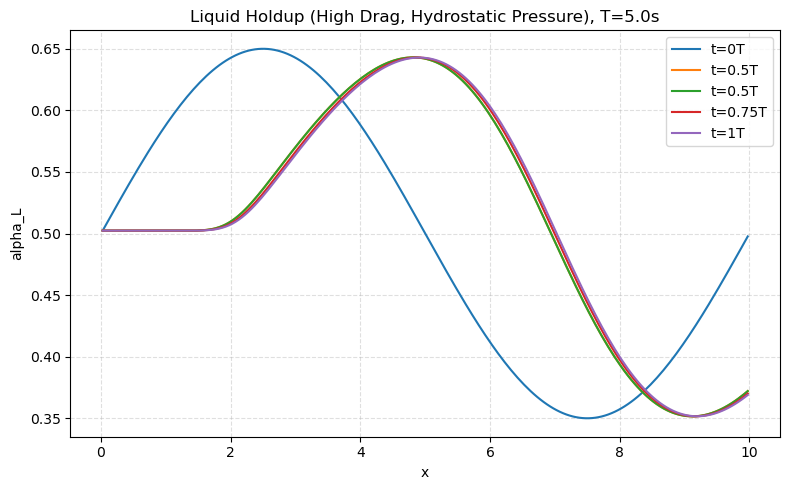

In [12]:
theta_test = np.array([1, 1, 1, 0.8, 0.02])
all_data_L, timesteps = two_phase_simulator(theta_test, T=5.0, N=200, L=10.0)

plt.figure(figsize=(8, 5))
time_fractions = [0, 0.5, 0.5, 0.75, 1.0]
labels = [f't={frac:.2g}T' for frac in time_fractions]
for frac, label in zip(time_fractions, labels):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title(f"Liquid Holdup (High Drag, Hydrostatic Pressure), T={T}s")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [7]:
def simulator_wrapper(theta):
    alpha_L, alpha_G, u_L, u_G, _ = two_phase_simulator(theta, return_full=True)
    return torch.tensor(enriched_summary(alpha_L, alpha_G, u_L, u_G), dtype=torch.float32)

In [8]:

prior_low  = torch.tensor([0.01, 0.01, 0.01, 0.0, 0.0])  # Add h_sed (min 0)
prior_high = torch.tensor([1.,  1.,   1.,   0.8, 0.05])  # Add h_sed (max reasonable)

prior = BoxUniform(low=prior_low, high=prior_high)

limits = [[l, h] for l, h in zip(prior_low, prior_high)]

example_theta = [0.005, 0.003, 0.01, 1000.0, 1.2, 0.4]

In [9]:
# --- Generate Training Data ---
num_simulations = 2000  # Or more, if feasible
theta_bank = prior.sample((num_simulations,))
x_bank = []
for i in range(num_simulations):
    x_i = simulator_wrapper(theta_bank[i].numpy())
    x_bank.append(x_i)
    if i % 100 == 0:
        print(f"Sim {i}/{num_simulations}", end="\r")

x_bank = torch.stack(x_bank)

In [13]:
from sbi.inference import NPE

density_estimator = NPE(prior)
density_estimator.append_simulations(theta_bank, x_bank)
density_estimator.train()
posterior = density_estimator.build_posterior()

 Neural network successfully converged after 305 epochs.

Drawing 1000 posterior samples: 1235it [00:00, 23223.44it/s]            


Posterior samples shape: torch.Size([1000, 5])

Parameter Inference Results:
--------------------------------------------------------------------------------
Parameter   True Value  Mean        Median      Abs Error   % Error     RMSE        
--------------------------------------------------------------------------------
C_wall_L     0.8155 0.7473 0.7268 0.0682 8.37% 0.1239
C_wall_G     0.6099 0.6212 0.6230 0.0113 1.85% 0.0335
C_int        0.2382 0.2121 0.2093 0.0261 10.96% 0.0773
theta_incline 0.3897 0.4970 0.4785 0.1073 27.54% 0.1774
h_sed        0.0200 0.0223 0.0227 0.0023 11.60% 0.0043
--------------------------------------------------------------------------------
Average Absolute Error: 0.0431
Average Percentage Error: 12.06%
Average RMSE: 0.0833


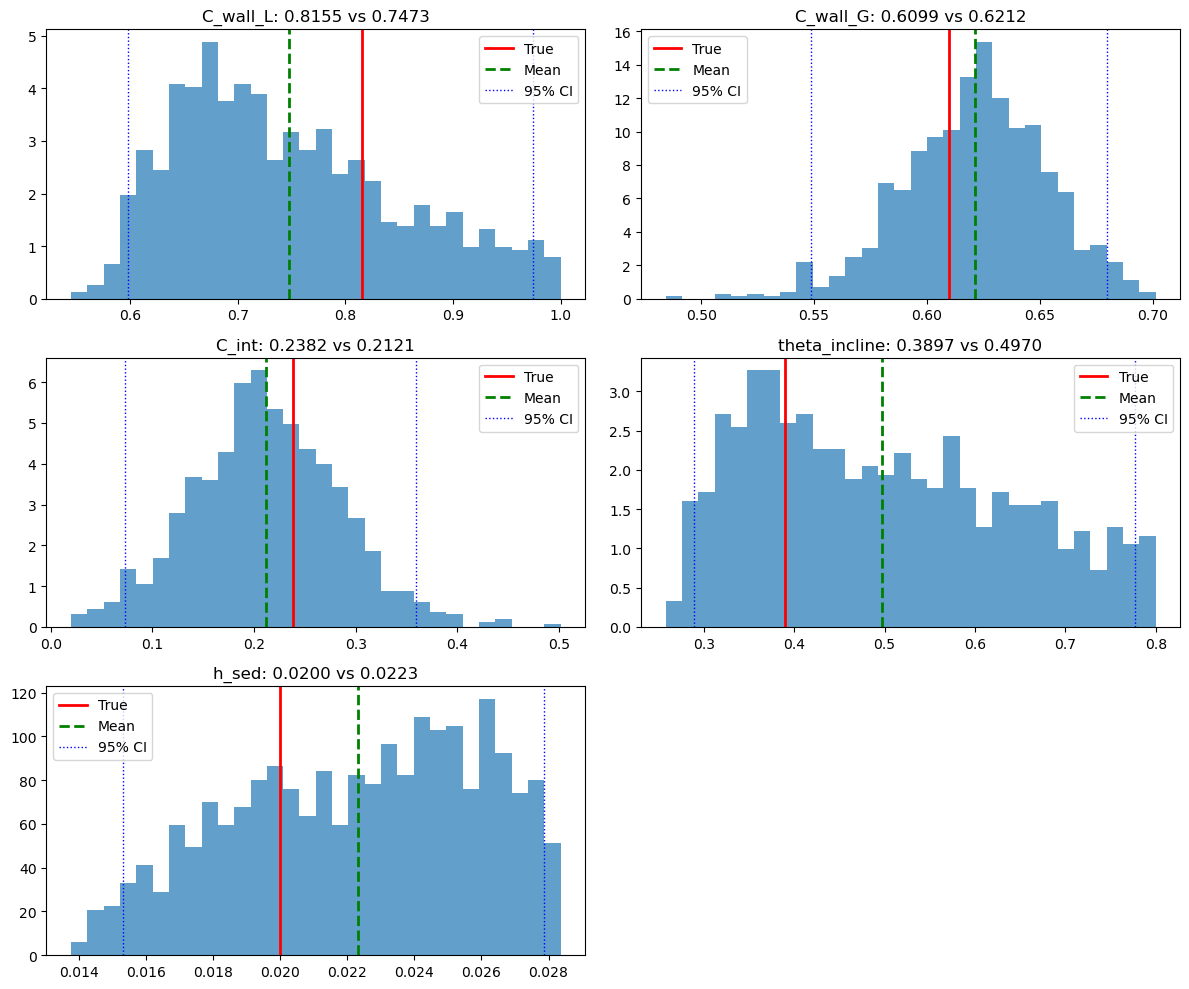

In [15]:
theta_true = torch.tensor([0.8155, 0.6099, 0.2382, 0.3897, 0.02])
x_o = simulator_wrapper(theta_true.numpy())
samples = posterior.sample((1000,), x=x_o)
print("Posterior samples shape:", samples.shape)


import torch

# Calculate mean and median of posterior samples
theta_mean = samples.mean(dim=0)
theta_median = samples.median(dim=0)[0]

# Calculate error metrics
abs_error = torch.abs(theta_mean - theta_true)
rel_error = abs_error / theta_true * 100  # percentage error
mse = torch.mean((samples - theta_true)**2, dim=0)
rmse = torch.sqrt(mse)

# Print results in a formatted table
print("\nParameter Inference Results:")
print("-" * 80)
print(f"{'Parameter':<12}{'True Value':<12}{'Mean':<12}{'Median':<12}{'Abs Error':<12}{'% Error':<12}{'RMSE':<12}")
print("-" * 80)

for i, name in enumerate(param_names):
    print(f"{name:<12} {theta_true[i]:.4f} {theta_mean[i]:.4f} {theta_median[i]:.4f} {abs_error[i]:.4f} {rel_error[i]:.2f}% {rmse[i]:.4f}")

print("-" * 80)
print(f"Average Absolute Error: {abs_error.mean():.4f}")
print(f"Average Percentage Error: {rel_error.mean():.2f}%")
print(f"Average RMSE: {rmse.mean():.4f}")

# Visualize the true parameter vs inferred (mean and 95% CI)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Use param_names_sed which contains all 5 parameters
for i, name in enumerate(param_names):
    # Extract 95% credible interval
    q_low, q_high = torch.quantile(samples[:, i], torch.tensor([0.025, 0.975]))
    
    ax = axes[i]
    ax.hist(samples[:, i].numpy(), bins=30, alpha=0.7, density=True)
    ax.axvline(theta_true[i], color='r', linestyle='-', linewidth=2, label='True')
    ax.axvline(theta_mean[i], color='g', linestyle='--', linewidth=2, label='Mean')
    ax.axvline(q_low, color='b', linestyle=':', linewidth=1, label='95% CI')
    ax.axvline(q_high, color='b', linestyle=':', linewidth=1)
    ax.set_title(f"{name}: {theta_true[i]:.4f} vs {theta_mean[i]:.4f}")
    ax.legend()

# Hide the unused subplot
if len(param_names) < 6:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()


Parameter Inference Results:
--------------------------------------------------------------------------------------------------------------
Parameter   True      Inferred  Std       2.5% CI   97.5% CI  Abs. Error  Rel. Error(%)  RMSE      
--------------------------------------------------------------------------------------------------------------
C_wall_L     0.8155    0.7473    0.1035    0.5979    0.9739    0.0682      8.37%        0.1239
C_wall_G     0.6099    0.6212    0.0316    0.5488    0.6795    0.0113      1.85%        0.0335
C_int        0.2382    0.2121    0.0728    0.0726    0.3593    0.0261      10.96%        0.0773
theta        0.3897    0.4970    0.1413    0.2890    0.7767    0.1073      27.54%        0.1774
h_sed        0.0200    0.0223    0.0036    0.0153    0.0279    0.0023      11.60%        0.0043
--------------------------------------------------------------------------------------------------------------
Average Absolute Error: 0.0431
Average Percentage Error: 12

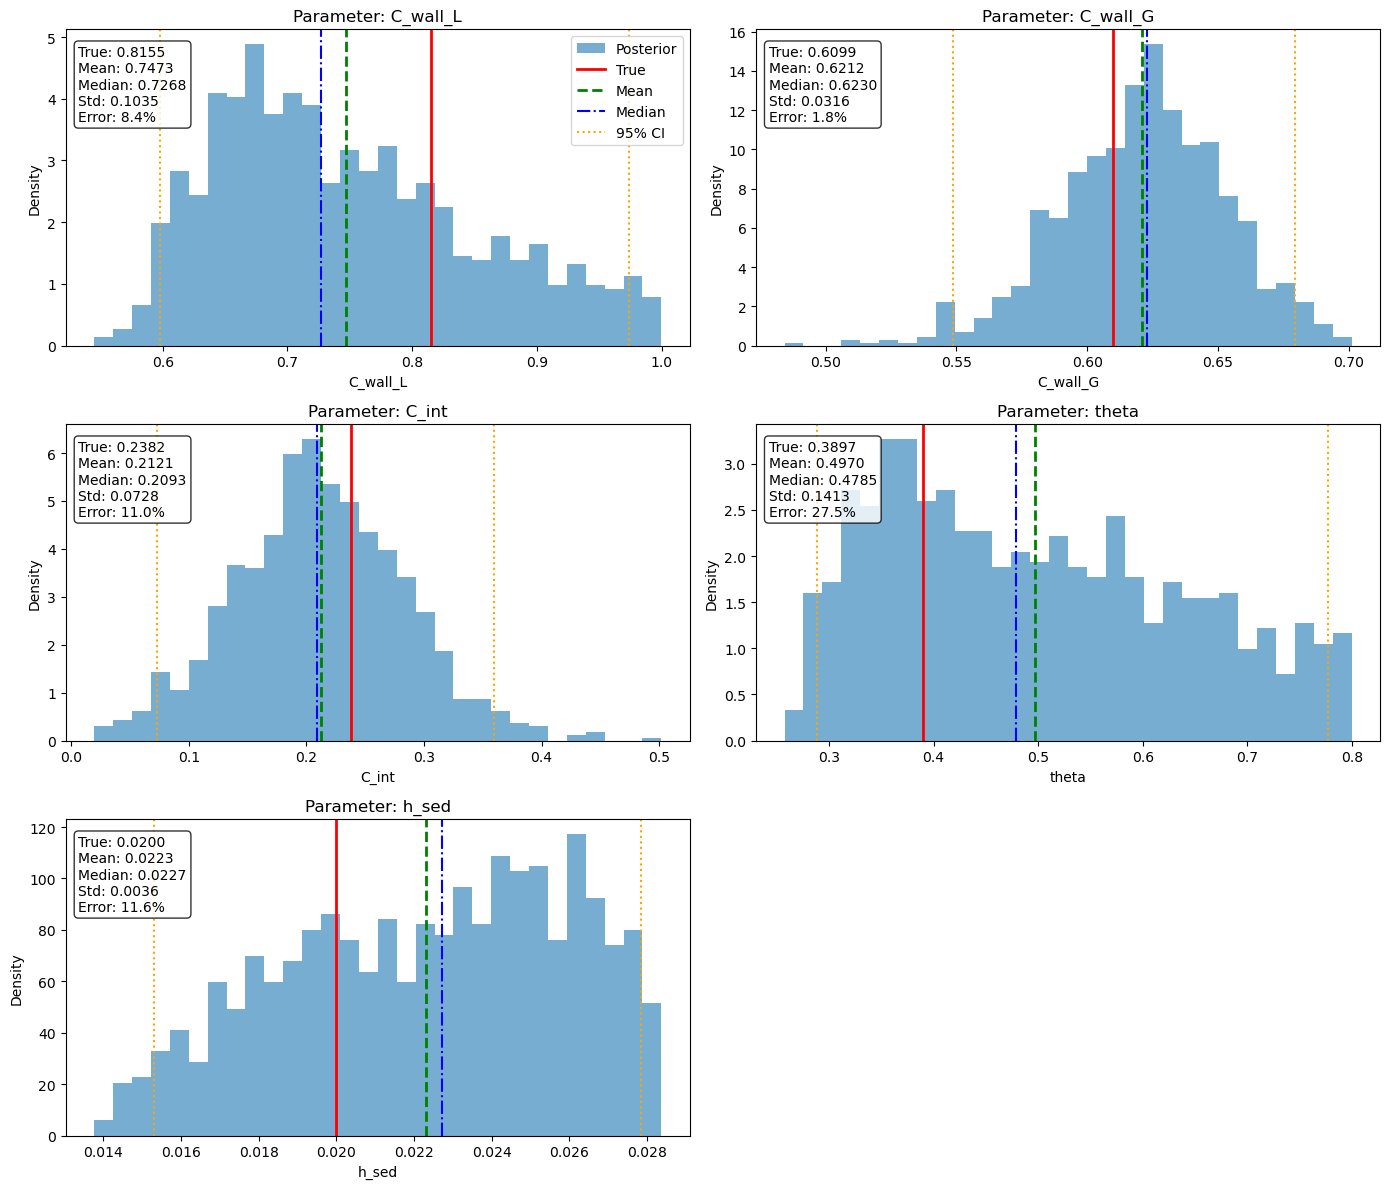

/tmp/ipykernel_73118/979844085.py:81: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig = analysis.pairplot(


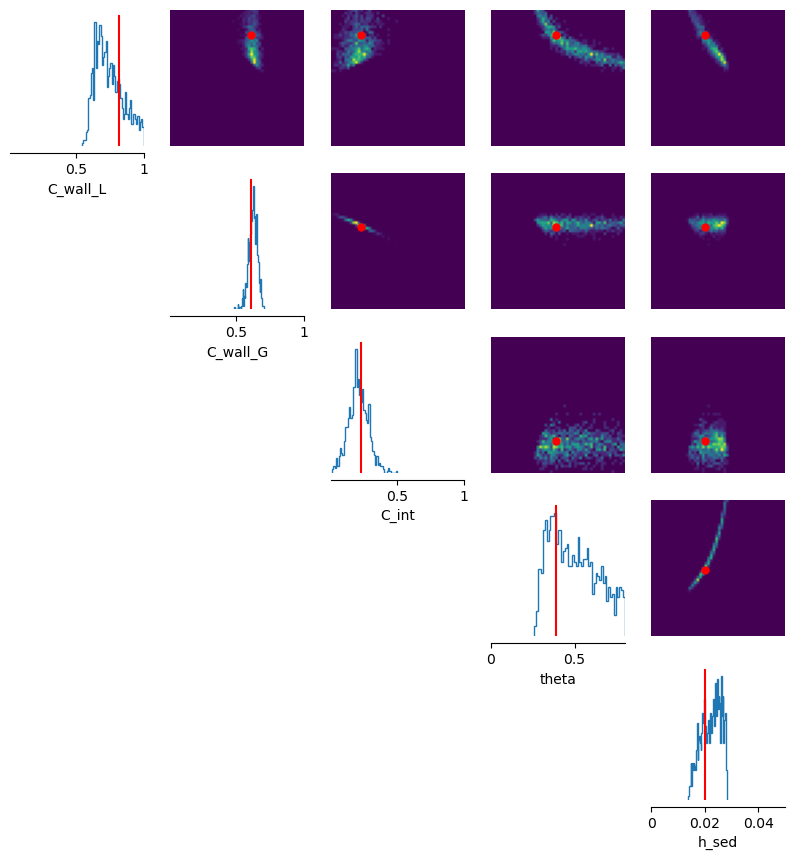

In [17]:
import torch

# Calculate mean, median, and std of posterior samples
theta_mean = samples.mean(dim=0)
theta_median = samples.median(dim=0)[0]
theta_std = samples.std(dim=0)

# Calculate confidence intervals
ci_low, ci_high = torch.quantile(samples, torch.tensor([0.025, 0.975]), dim=0)

# Calculate error metrics
abs_error = torch.abs(theta_mean - theta_true)
rel_error = abs_error / theta_true * 100  # percentage error
mse = torch.mean((samples - theta_true)**2, dim=0)
rmse = torch.sqrt(mse)

# Print results in a formatted table
print("\nParameter Inference Results:")
print("-" * 110)
print(f"{'Parameter':<12}{'True':<10}{'Inferred':<10}{'Std':<10}{'2.5% CI':<10}{'97.5% CI':<10}{'Abs. Error':<12}{'Rel. Error(%)':<15}{'RMSE':<10}")
print("-" * 110)

for i, name in enumerate(param_names):
    print(f"{name:<12} {theta_true[i]:.4f}    {theta_mean[i]:.4f}    {theta_std[i]:.4f}    {ci_low[i]:.4f}    {ci_high[i]:.4f}    {abs_error[i]:.4f}      {rel_error[i]:.2f}%        {rmse[i]:.4f}")

print("-" * 110)
print(f"Average Absolute Error: {abs_error.mean():.4f}")
print(f"Average Percentage Error: {rel_error.mean():.2f}%")
print(f"Average RMSE: {rmse.mean():.4f}")

# Visualize the true parameter vs inferred (mean and 95% CI)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten to make indexing easier

for i, name in enumerate(param_names):
    ax = axes[i]
    # Plot histogram with KDE
    sns_plot = ax.hist(samples[:, i].numpy(), bins=30, alpha=0.6, density=True, label='Posterior')
    
    # Add vertical lines for true value, mean, median and CI
    ax.axvline(theta_true[i], color='r', linestyle='-', linewidth=2, label='True')
    ax.axvline(theta_mean[i], color='g', linestyle='--', linewidth=2, label='Mean')
    ax.axvline(theta_median[i], color='b', linestyle='-.', linewidth=1.5, label='Median')
    ax.axvline(ci_low[i], color='orange', linestyle=':', linewidth=1.5, label='95% CI')
    ax.axvline(ci_high[i], color='orange', linestyle=':', linewidth=1.5)
    
    # Add text with statistics
    stats_text = f"True: {theta_true[i]:.4f}\nMean: {theta_mean[i]:.4f}\nMedian: {theta_median[i]:.4f}\nStd: {theta_std[i]:.4f}\nError: {rel_error[i]:.1f}%"
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f"Parameter: {name}")
    ax.set_xlabel(f"{name}")
    ax.set_ylabel("Density")
    
    # Only show legend on first plot to save space
    if i == 0:
        ax.legend(loc='upper right')

# Hide the unused subplot if needed
if len(param_names) < 6:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()

# Create pairplot using sbi analysis module
from sbi import analysis

# Ensure data is in torch format
if isinstance(samples, np.ndarray):
    samples = torch.tensor(samples)
if isinstance(theta_true, np.ndarray):
    theta_true = torch.tensor(theta_true, dtype=samples.dtype)

# If observation is batched, select one
if theta_true.ndim == 2 and theta_true.shape[0] == 1:
    theta_true = theta_true[0]

# Create pairplot
fig = analysis.pairplot(
    samples,
    points=theta_true[None, :],  # needs shape (1, ndim)
    labels=param_names,
    points_colors="r",
    limits=limits
)

/tmp/ipykernel_29288/2203469690.py:21: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig = analysis.pairplot(


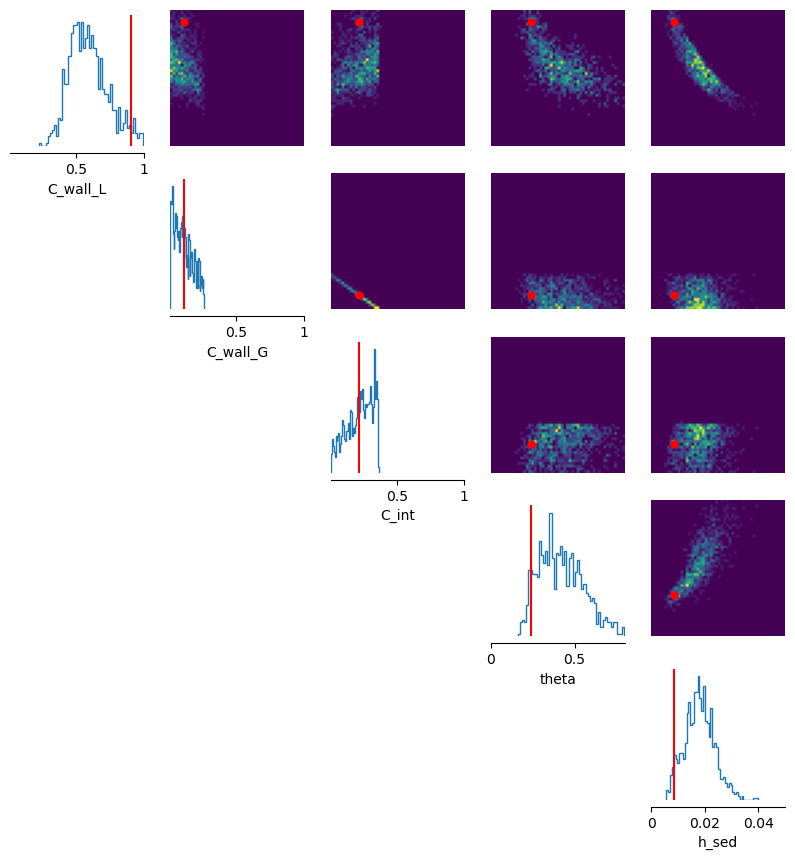

In [25]:
from sbi import analysis


# If your samples and theta_true are numpy, convert to torch
if isinstance(samples, np.ndarray):
    samples = torch.tensor(samples)
if isinstance(theta_true, np.ndarray):
    theta_true = torch.tensor(theta_true, dtype=samples.dtype)



param_names = [
    "C_wall_L", "C_wall_G", "C_int", "theta", "h_sed"
]

# If your observation is batched, select one (x_o)
if theta_true.ndim == 2 and theta_true.shape[0] == 1:
    theta_true = theta_true[0]

# pairplot returns the matplotlib Figure
fig = analysis.pairplot(
    samples,
    points=theta_true[None, :],  # needs shape (1, ndim)
    labels=param_names,
    points_colors="r",
    limits=limits
)